In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import re
#隐藏代码
from IPython.display import display_html 
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)


Toggle Code

In [2]:
#列名转换字典
dict_columns={'总质量（吨）':'总质量（kg）','车长（米）':'外形尺寸（长×宽×高）长（mm）','电池电压（V）':'储能装置总成标称电压（V）','电池电量（kWh）':'储能装置总储电量（kWh）'}
dict_columns_opposit={v:k for k,v in dict_columns.items()}


In [3]:
#原始数据载入
primary_data=pd.read_excel(r"C:\Users\chirs\Documents\Python\Catalogue\292-302.xlsx",sheetname="280-301")
#提取目标数据
data=primary_data[['产品型号','产品商标','产品名称','批次','车辆类型','外形尺寸（长×宽×高）长（mm）','总质量（kg）','整备质量（kg）','准拖挂车总质量（kg）','驱动电机安装数量','变速器档位数','变速器各档位传动比','主减速器速比(驱动桥速比)','电动汽车驱动电机额定功率/转速/转矩（kW/r/min/N.m）','电动汽车驱动电机峰值功率/转速/转矩（kW/r/min/N.m）','后桥（轴）生产企业','电动汽车驱动电机生产企业','储能装置总储电量（kWh）','储能装置总成标称电压（V）','储能装置总成质量（kg）','电动汽车储能装置种类']]

In [4]:
#数据清洗
def num_extract(extract_str,integer,emptyReturn,returnnum):
    if integer=='integer':
        Rexp='\d+'
    elif integer=='decimal':
        Rexp='\d{1,5}(?:\.\d+)?'
    else:
        print('Error input in num_extract')
    if type(extract_str)==str:
        extract_str=re.findall(Rexp,extract_str)
        if extract_str==[]:
            extract_str=np.array([emptyReturn])
        else:
            extract_str=np.array(list(map(float,extract_str)))
            if returnnum==1:
                extract_str=float(extract_str.max())
    return(extract_str)

data=data.sort_values(by='批次',ascending=False)
data=data.drop_duplicates(subset='产品型号',keep='first')
data=data.fillna({'主减速器速比(驱动桥速比)':float(1),'变速器各档位传动比':float(1),'准拖挂车总质量（kg）':int(0),'整备质量（kg）':int(0)})
for i in data.index:
    if '城市客车' in data.loc[i,'产品名称']:
        data.loc[i,'车型大类']='公交'
    elif '客车' in data.loc[i,'产品名称']:  
        data.loc[i,'车型大类']='大巴'
    elif '乘用车' in data.loc[i,'产品名称']:
        data.loc[i,'车型大类']='乘用车'
    else:
        data.loc[i,'车型大类']='卡车'
    if '纯电动' not in data.loc[i,'产品名称']:
        data=data.drop([i])
#计算轮端最大扭矩与额定输出功率    
    try:
        motor_num=data.loc[i,'驱动电机安装数量']
        motor_num=num_extract(motor_num,'integer',1,1)
        motor_e=data.loc[i,'电动汽车驱动电机额定功率/转速/转矩（kW/r/min/N.m）']
        motor_e=num_extract(motor_e,'decimal',0,0)
        Pe=float(motor_e[0])
        data.loc[i,'额定输出功率（kW）']=Pe*motor_num
        motor_z=data.loc[i,'电动汽车驱动电机峰值功率/转速/转矩（kW/r/min/N.m）']
        motor_z=num_extract(motor_z,'decimal',0,0)
        Tz=float(motor_z[2])
        nz=float(motor_z[1])
        data.loc[i,'电机最大扭矩']=Tz*motor_num
        data.loc[i,'电机最高转速']=nz
        i1,i0=data.loc[i,['变速器各档位传动比','主减速器速比(驱动桥速比)']]
        i1=num_extract(i1,'decimal',1,0)
        i0=num_extract(i0,'decimal',1,1)
        if type(i1)==float:
            data.loc[i,'驱动形式']='直驱'
            data.loc[i,'轮端最大扭矩（kNm）']=Tz*i1*i0*motor_num/1000
        else:
            data.loc[i,'轮端最大扭矩（kNm）']=Tz*i1.max()*i0*motor_num/1000
        if len(i1)==1:
                data.loc[i,'驱动形式']='直驱'
        else:
                data.loc[i,'驱动形式']='非直驱'
        W_battery=data.loc[i,'储能装置总储电量（kWh）']
        m_battery=data.loc[i,'储能装置总成质量（kg）']
        W_battery=num_extract(W_battery,'decimal',0,1)
        m_battery=num_extract(m_battery,'decimal',0,1)
        data.loc[i,'储能装置能量密度（Wh/kg）']=W_battery/m_battery*1000
        data.loc[i,'驱动电机安装数量']=motor_num
        data.loc[i,['变速器各档位传动比','主减速器速比(驱动桥速比)']]=i1,i0
    except:
        pass
#清洗质量与车长
data[['总质量（kg）','整备质量（kg）','准拖挂车总质量（kg）','外形尺寸（长×宽×高）长（mm）']].astype(int,copy='False',errors='ignore')
for i in data.index:
    m_full=data.loc[i,'总质量（kg）']
    m_curb=data.loc[i,'整备质量（kg）']
    m_trailer=data.loc[i,'准拖挂车总质量（kg）']
    length=data.loc[i,'外形尺寸（长×宽×高）长（mm）']
    m_full=num_extract(m_full,'integer',0,1)
    m_curb=num_extract(m_curb,'integer',0,1)
    m_trailer=num_extract(m_trailer,'integer',0,1)
    length=num_extract(length,'integer',0,1)
    if m_trailer!=0:
        m_full=m_full+m_trailer
    data.loc[i,'总质量（kg）']=m_full
    data.loc[i,'总质量（t）']=m_full/1000
    data.loc[i,'整备质量（kg）']=m_curb
    data.loc[i,'准拖挂车总质量（kg）']=m_trailer
    data.loc[i,'外形尺寸（长×宽×高）长（mm）']=length
    data.loc[i,'外形尺寸长（m）']=length/1000
    voltage=data.loc[i,'储能装置总成标称电压（V）']
    electricity=data.loc[i,'储能装置总储电量（kWh）']
    voltage=num_extract(voltage,'decimal',0,1)
    electricity=num_extract(electricity,'decimal',0,1)
    data.loc[i,'储能装置总成标称电压（V）']=voltage
    data.loc[i,'储能装置总储电量（kWh）']=electricity


In [5]:
#数据分类
menue_EV=data.groupby(['车型大类'])
menue_EV=dict(list(menue_EV))
EVtruck=pd.DataFrame(menue_EV['卡车'])
EVbus=pd.DataFrame(menue_EV['公交'])
EVcoach=pd.DataFrame(menue_EV['大巴']) 
#添加细分车型标签
#卡车按吨位细分
truck_classifi=np.array([2800,3500,4500,7500,12000,14000,16000,18000,25000,32000])
EVtruck['车型细分']='%st'%(truck_classifi[0]/1000)
for i in np.arange(0,len(truck_classifi)-1):
    a=EVtruck[EVtruck['总质量（kg）']<truck_classifi[-(1+i)]].index
    b=EVtruck[EVtruck['总质量（kg）']<truck_classifi[-(2+i)]].index
    c=a.difference(b)
    EVtruck.loc[c,'车型细分']='%st'%(truck_classifi[-(1+i)]/1000)

#大巴按米端细分
length=EVcoach['外形尺寸（长×宽×高）长（mm）']
length=(length/1000).apply(math.floor)
for i in length.index:
    length[i]=str(length[i])+'米'
EVcoach['车型细分']=length
# 公交按米段细分
length=EVbus['外形尺寸（长×宽×高）长（mm）']
length=(length/1000).apply(math.floor)
for i in length.index:
    length[i]=str(length[i])+'米'
EVbus['车型细分']=length

In [6]:
from ipywidgets import widgets,interact
from IPython.display import display
import IPython

In [7]:
cv_type=widgets.Dropdown(
    options=['卡车', '城市客车', '旅游客车'],
    value='卡车',
    description='车型:',
    disabled=False,
)
cv_type_dict={'卡车':EVtruck,'城市客车':EVbus,'旅游客车':EVcoach}
cv_time_range=widgets.FloatRangeSlider(
    min=cv_type_dict[cv_type.value]['批次'].min(),
    max=cv_type_dict[cv_type.value]['批次'].max(),
    value=[cv_type_dict[cv_type.value]['批次'].min(),cv_type_dict[cv_type.value]['批次'].max()],
    step=1,
    description='批次:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
cv_brand=widgets.Dropdown(
    options=list(cv_type_dict[cv_type.value]['产品商标'].value_counts().index.values),
    value=cv_type_dict[cv_type.value]['产品商标'].value_counts().index[0],
    description='产品商标:',
    disabled=False,
)
cv_subtype=widgets.Dropdown(
    options=list(cv_type_dict[cv_type.value]['车型细分'].value_counts().index.values),
    value=cv_type_dict[cv_type.value]['车型细分'].value_counts().index[0],
    description='车型细分:',
    disabled=False,
)
cv_xlabel=widgets.Dropdown(
    options=['总质量（t）','外形尺寸长（m）'],
    value='总质量（t）',
    description='X轴值:',
    disabled=False,
)
cv_ylabel=widgets.Dropdown(
    options=['轮端最大扭矩（kNm）','额定输出功率（kW）','储能装置总成标称电压（V）','储能装置总储电量（kWh）','储能装置能量密度（Wh/kg）'],
    value='轮端最大扭矩（kNm）',
    description='Y轴值:',
    disabled=False,
)
cv_xlabel_range=widgets.FloatRangeSlider(
    min=cv_type_dict[cv_type.value][cv_xlabel.value].min(),
    max=cv_type_dict[cv_type.value][cv_xlabel.value].max(),
    value=[cv_type_dict[cv_type.value][cv_xlabel.value].min(),cv_type_dict[cv_type.value][cv_xlabel.value].max()],
    step=0.1,
    description='X轴范围:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
cv_ylabel_range=widgets.FloatRangeSlider(
    min=cv_type_dict[cv_type.value][cv_ylabel.value].min(),
    max=cv_type_dict[cv_type.value][cv_ylabel.value].max(),
    value=[cv_type_dict[cv_type.value][cv_ylabel.value].min(),cv_type_dict[cv_type.value][cv_ylabel.value].max()],
    step=0.1,
    description='Y轴范围:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
cv_button=widgets.Button(
    value=False,
    description='生成图像',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)
cv_button2=widgets.Button(
    value=False,
    description='详细参数',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

In [8]:
def cv_type_change(change):
    cv_brand.value=cv_type_dict[cv_type.value]['产品商标'].value_counts().index[0]
    cv_brand.options=list(cv_type_dict[cv_type.value]['产品商标'].value_counts().index.values)
    cv_xlabel_range.min=cv_type_dict[cv_type.value][cv_xlabel.value].min()
    cv_xlabel_range.max=cv_type_dict[cv_type.value][cv_xlabel.value].max()
    cv_xlabel_range.value=[cv_type_dict[cv_type.value][cv_xlabel.value].min(),cv_type_dict[cv_type.value][cv_xlabel.value].max()]
    cv_ylabel_range.min=cv_type_dict[cv_type.value][cv_ylabel.value].min()
    cv_ylabel_range.max=cv_type_dict[cv_type.value][cv_ylabel.value].max()
    cv_ylabel_range.value=[cv_type_dict[cv_type.value][cv_ylabel.value].min(),cv_type_dict[cv_type.value][cv_ylabel.value].max()]
cv_type.observe(cv_type_change,names='value')
def cv_xlabel_change(change):
    cv_xlabel_range.min=cv_type_dict[cv_type.value][cv_xlabel.value].min()
    cv_xlabel_range.max=cv_type_dict[cv_type.value][cv_xlabel.value].max()
    cv_xlabel_range.value=[cv_type_dict[cv_type.value][cv_xlabel.value].min(),cv_type_dict[cv_type.value][cv_xlabel.value].max()]
cv_xlabel.observe(cv_xlabel_change,names='value')
def cv_ylabel_change(change):
    cv_ylabel_range.min=cv_type_dict[cv_type.value][cv_ylabel.value].min()
    cv_ylabel_range.max=cv_type_dict[cv_type.value][cv_ylabel.value].max()
    cv_ylabel_range.value=[cv_type_dict[cv_type.value][cv_ylabel.value].min(),cv_type_dict[cv_type.value][cv_ylabel.value].max()]
cv_ylabel.observe(cv_ylabel_change,names='value')

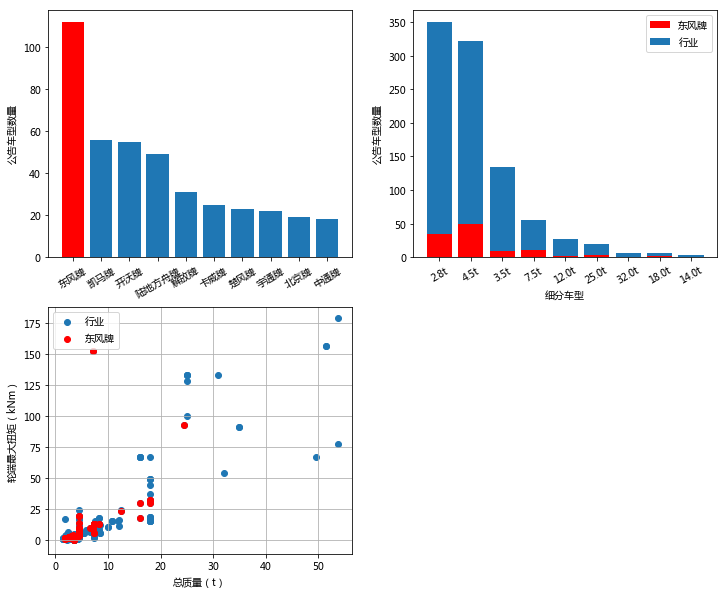

<function __main__.f>

In [9]:
def f(cvtime,cvtype='卡车',cvbrand='东风',xlabel='总质量（t）',xrange=[cv_type_dict[cv_type.value][cv_xlabel.value].min(),cv_type_dict[cv_type.value][cv_xlabel.value].max()],ylabel='轮端最大扭矩（kNm）',yrange=[cv_type_dict[cv_type.value][cv_ylabel.value].min(),cv_type_dict[cv_type.value][cv_ylabel.value].max()]):
    reference=cv_brand.value
    EV=cv_type_dict[cv_type.value]
    EV=EV[EV['批次']<cvtime[1]]
    EV=EV[EV['批次']>cvtime[0]]
    EV_reference=EV[EV['产品商标']==reference]
    reference_color='r'
    fig=plt.figure(1,figsize=(12,10))
    ax1=fig.add_subplot(2,2,1)
    ax2=fig.add_subplot(2,2,2)
    ax3=fig.add_subplot(2,2,3)
    #ax1=fig.add_subplot(2,2,1)
    brand=EV['产品商标'].value_counts()[:10]
    ax1.bar(np.arange(10),brand)
    ax1.set_xticks(np.arange(10))
    ax1.set_xticklabels(brand.index.values,rotation=30)
    if reference in brand.index:
        reference_loc=brand.index.get_loc(reference)
        ax1.bar(reference_loc,brand.iloc[reference_loc],color=reference_color)
    ax1.set_ylabel('公告车型数量')

    #ax2=fig.add_subplot(2,2,2)
    brand=EV['车型细分'].value_counts()
    reference_brand=EV_reference['车型细分'].value_counts()
    brand=pd.DataFrame({0:brand,1:reference_brand})
    brand=brand.fillna(0)
    brand[0]=brand[0]-brand[1]
    brand=brand.sort_values(by=0,ascending=False)
    ax2.bar(np.arange(brand.index.size),brand[1],color=reference_color,label=reference)
    ax2.bar(np.arange(brand.index.size),brand[0],bottom=brand[1],label='行业')
    ax2.set_xticks(np.arange(brand.index.size))
    ax2.set_xticklabels(brand.index.values,rotation=30)
    ax2.legend(loc='best')
    #plt.bar(np.arange(brand.index.size),reference_brand,color='r') 
    ax2.set_xlabel('细分车型')
    ax2.set_ylabel('公告车型数量')
    plt.subplots_adjust(wspace=0.2)
    
    
    EV=EV[EV[xlabel]<xrange[1]]
    EV=EV[EV[ylabel]<yrange[1]]
    EV=EV[EV[xlabel]>xrange[0]]
    EV=EV[EV[ylabel]>yrange[0]]
    EV_reference=EV[EV['产品商标']==reference]
    ax3.scatter(EV[xlabel],EV[ylabel],label='行业')
    ax3.scatter(EV_reference[xlabel],EV_reference[ylabel],color=reference_color,label=reference)
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel(ylabel)
    plt.grid()
    ax3.legend(loc='best')
    #return EV.iloc[:10,[0,1,3,9,11,12,14]]
interact(f,cvtime=cv_time_range,cvtype=cv_type,cvbrand=cv_brand,xlabel=cv_xlabel,xrange=cv_xlabel_range,ylabel=cv_ylabel,yrange=cv_ylabel_range)

In [10]:
sum??


In [11]:
pd.pivot??